## Stochastic elliptic equation
$-\frac{d}{dx}\left(k(x;\omega)\frac{d}{dx}u\right) = f(x),\quad x\in[-1,1]\,\mathrm{~and~}\omega\in\Omega,$

$u(-1) = u(1) = 0$  

$f(x) = 10$

$log(k(x,w)) \sim GP(k_0(x), k(x,x'))$  

$k_0(x) = \sin(\frac{3}{2}\pi x)/5$ 

$k(x,x') = \sigma^2 \exp\left(-\frac{(x-x')^2}{l^2}\right)$

Where:  
$\sigma = 0.1$ and $l = 1$

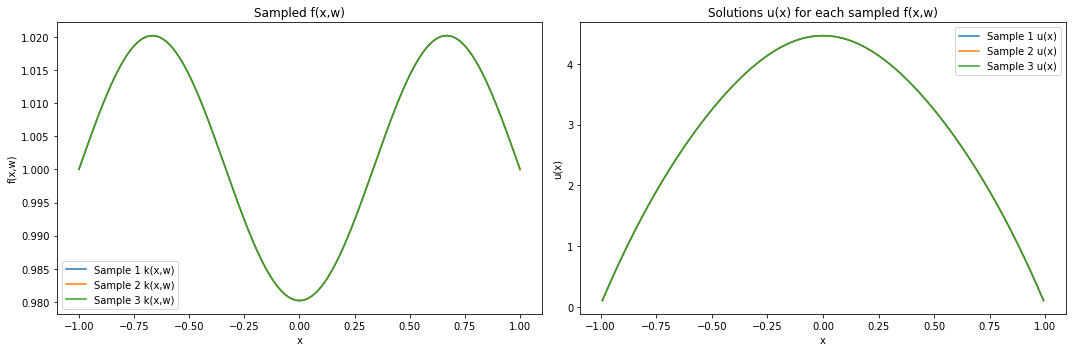

u[-1] for each sample: [0.03481315 0.03481315 0.03481315]
u[1] for each sample: [0.03481315 0.03481315 0.03481315]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

# Define parameters
sigma = 0.1
l = 1
n_points = 1000
x = np.linspace(-1, 1, n_points)

# Define the mean function and the kernel

k0 = lambda x: np.sin(3/2*np.pi * x-np.pi/2)/50
# k0 = lambda x: np.zeros(len(x))


def kernel(x, x_prime, sigma=sigma, l=l):
    return sigma**2 * np.exp(-((x-x_prime)**2) / l**2)

# Sample from the GP
def sample_GP(x, n_samples=1):
    mu = k0(x)
    K = np.array([[kernel(xi, xj) for xj in x] for xi in x])
    return np.random.multivariate_normal(mu, K, n_samples)

# Finite differences using scipy's sparse matrix to solve the Poisson equation


def solve_elliptic(k, f_value=10, u_left=0, u_right=0):
    """
    Solve the elliptic equation using finite difference for given k and f.

    Parameters:
    - k: Array representing the spatially varying coefficient.
    - f: Source term. Default is an array of 10s.
    - u_left: Boundary condition at the left end. Default is 0.
    - u_right: Boundary condition at the right end. Default is 0.

    Returns:
    - u: Solution of the elliptic equation.
    """
    
    N = len(k)
    dx = 2 / (N - 1) # x is in [-1, 1]
    f_extended = np.zeros(N+4)
    f_extended[2:-2] = np.full(N, f_value)

    # Incorporate k into the diagonals
    #Extend k and f with virtual points
    k_extended = np.ones(N+4)
    k_extended[2:-2] = k

    # Incorporate k into the diagonals
    main_diag = np.zeros(N+4)
    off_diag_left = np.zeros(N+3)
    off_diag_right = np.zeros(N+3)
    
    for i in range(1, N+3):
        main_diag[i] = -2*k_extended[i]
        off_diag_left[i-1] = k_extended[i-1]
        off_diag_right[i] = k_extended[i+1]

    # Using virtual points to enforce boundary conditions
    main_diag[0] = main_diag[-1] = -2*k_extended[0]
    f_extended[1] = u_left*k_extended[2]/dx**2
    f_extended[-2] = u_right*k_extended[-3]/dx**2

    diagonals = [main_diag, off_diag_right, off_diag_left]
    A = diags(diagonals, [0, 1, -1], format="csr")/dx**2*np.log(10)/2

    u_full = spsolve(A, -f_extended)

    # Return u without the ghost points
    return u_full[2:-2]


n_samples = 3
log_k_samples = sample_GP(x, n_samples)
# log_k_samples = np.zeros((n_samples, n_points))
u_solutions = np.array([solve_elliptic(np.exp(k_sample)) for k_sample in log_k_samples])

plt.figure(figsize=(15, 5))

# Left subplot for f(x,w)
plt.subplot(1, 2, 1)
for i in range(n_samples):
    plt.plot(x, np.exp(log_k_samples[i]), label=f"Sample {i+1} k(x,w)")
plt.title("Sampled f(x,w)")
plt.xlabel('x')
plt.ylabel('f(x,w)')
plt.legend()

# Right subplot for u(x)
offset = 4
plt.subplot(1, 2, 2)
for i in range(n_samples):
    plt.plot(x[offset:-offset], u_solutions[i][offset:-offset], label=f"Sample {i+1} u(x)")
plt.title("Solutions u(x) for each sampled f(x,w)")
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()

plt.tight_layout()
plt.show()

# Print u[0] and u[-1] for each sample

u_left_boundary = u_solutions[:, 0]
u_right_boundary = u_solutions[:, -1]

print(f"u[-1] for each sample: {u_left_boundary}")
print(f"u[1] for each sample: {u_right_boundary}")

In [112]:
from icecream import ic
ic(6.93/6.08)
ic(np.log(10))

ic| 6.93/6.08: 1.1398026315789473
ic| np.log(10): 2.302585092994046


2.302585092994046

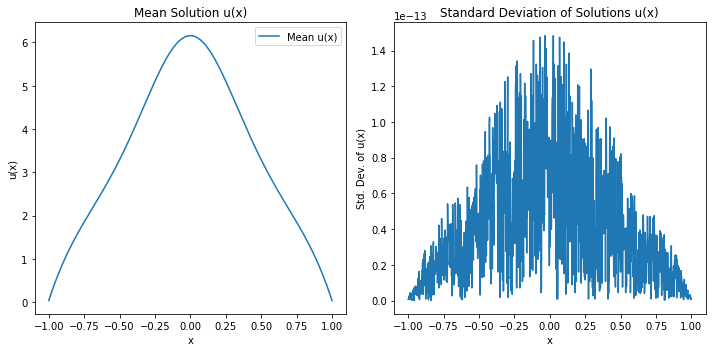

In [101]:
n_points = 1000
x = np.linspace(-1, 1, n_points)
dx = x[1] - x[0]

n_samples = 1000
# k0 = lambda x: np.zeros(len(x))


def kernel(x, x_prime, sigma=sigma, l=l):
    return sigma**2 * np.exp(-((x-x_prime)**2) / l**2)

# Sample from the GP
def sample_GP(x, n_samples=1):
    mu = k0(x)
    K = np.array([[kernel(xi, xj) for xj in x] for xi in x])
    return np.random.multivariate_normal(mu, K, n_samples)

# log_k_samples = np.zeros((n_samples, n_points))
log_k_samples = sample_GP(x, n_samples)

k_samples = np.exp(log_k_samples)
u_solutions = np.array([solve_elliptic(k_sample) for k_sample in k_samples])

# Calculate the mean and standard deviation along the sample axis
u_mean = u_solutions.mean(axis=0)
u_std = u_solutions.std(axis=0)

# Plot the mean and standard deviation side by side
plt.figure(figsize=(10, 5))

# Left subplot for mean of u(x)
plt.subplot(1, 2, 1)
plt.plot(x, u_mean, label="Mean u(x)")
# plt.fill_between(x, u_mean - u_std, u_mean + u_std, color='gray', alpha=0.5, label="±1 std. dev.")
plt.title("Mean Solution u(x)")
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()

# Right subplot for standard deviation of u(x)
plt.subplot(1, 2, 2)
plt.plot(x, u_std, label="Standard Deviation u(x)")
plt.title("Standard Deviation of Solutions u(x)")
plt.xlabel('x')
plt.ylabel('Std. Dev. of u(x)')

plt.tight_layout()
plt.show()


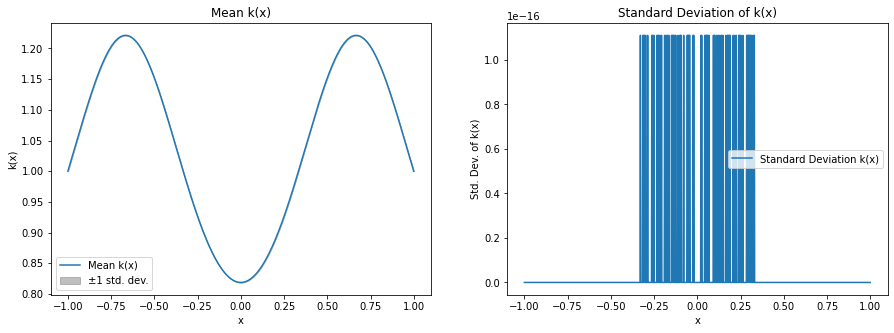

In [100]:
k_samples = np.exp(log_k_samples)

# Calculate the mean and standard deviation along the sample axis
k_mean = k_samples.mean(axis=0)
k_std = k_samples.std(axis=0)

# Plot the mean and standard deviation side by side
plt.figure(figsize=(15, 5))

# Left subplot for mean of k(x)
plt.subplot(1, 2, 1)
plt.plot(x, k_mean, label="Mean k(x)")
plt.fill_between(x, k_mean - k_std, k_mean + k_std, color='gray', alpha=0.5, label="±1 std. dev.")
plt.title("Mean k(x)")
plt.xlabel('x')
plt.ylabel('k(x)')
plt.legend()

# Right subplot for standard deviation of k(x)
plt.subplot(1, 2, 2)
plt.plot(x, k_std, label="Standard Deviation k(x)")
plt.title("Standard Deviation of k(x)")
plt.xlabel('x')
plt.ylabel('Std. Dev. of k(x)')
plt.legend()


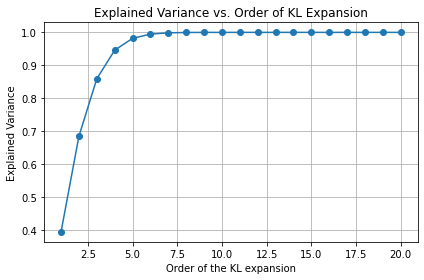

Truncation order for 99.0% explained variance: 6


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh

# Define the GP kernel
def kernel(x, x_prime, sigma=sigma, l=l):
    return sigma**2 * np.exp(-((x-x_prime)**2) / l**2)


def KL_expansion(x, kernel,truncation_order):
    """Compute the KL expansion of the GP prior defined by the kernel function."""
    K = np.array([[kernel(xi, xj) for xj in x] for xi in x])
    eigenvalues, eigenvectors = eigh(K)#,driver='evx')
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    for i in range(truncation_order):
        if eigenvectors[0, i] < 0:
            eigenvectors[:, i] *= -1
    return eigenvalues[:truncation_order], eigenvectors[:, :truncation_order]

eigenvalues, eigenvectors = KL_expansion(x, kernel, truncation_order=20)

# Compute the cumulative explained variance
explained_variance = np.cumsum(eigenvalues) / np.sum(eigenvalues)

# Plot explained variance
plt.figure()
n_orders = 20
plt.plot(np.arange(1, n_orders + 1), explained_variance[:n_orders], marker='o')
plt.xlabel('Order of the KL expansion')
plt.ylabel('Explained Variance')
plt.title('Explained Variance vs. Order of KL Expansion')
plt.grid(True)
plt.tight_layout()
plt.show()

# Propose truncation order based on a threshold
threshold = 0.99  # Example threshold for 99% explained variance
truncation_order = np.argmax(explained_variance >= threshold) + 1
print(f"Truncation order for {threshold*100}% explained variance: {truncation_order}")


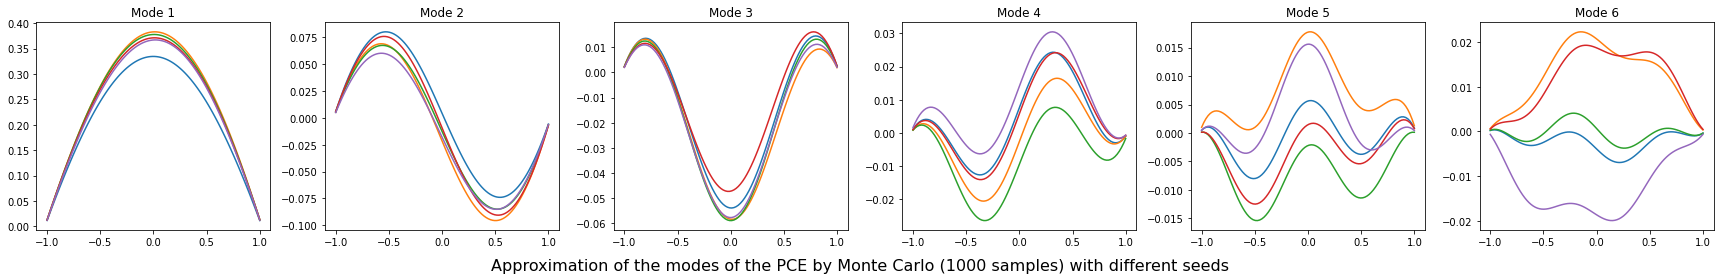

In [ ]:
#approximating PCE modes by Monte Carlo
def f_from_xi(xi, x_train, eigenvalues, eigenvectors, f0):
    """Compute the function f(x) from the random variables xi."""
    f_stoch = np.sqrt(eigenvalues) * xi @ eigenvectors.T
    f = f0(x_train) + f_stoch
    return f

n_xi_samples = 1000
n_x_points = 100 #spatial discretization/
truncation_order = 6
modes_functions = {}

x_test = np.linspace(-1, 1, n_x_points)
dx = x_test[1] - x_test[0]
eigenvalues, eigenvectors = KL_expansion(x_test, kernel, truncation_order)

for seed in range(0,5):
    np.random.seed(seed) # Set seed for reproducibility

    xi_test = np.random.randn(n_xi_samples, truncation_order)


    f_samples = [f_from_xi(xi, x_test, eigenvalues, eigenvectors, lambda x: 0) for xi in xi_test]

    u_solutions = np.array([solve_poisson(f_sample, dx) for f_sample in f_samples]) # Matrix of shape (n_samples, n_points)
    u_mean = f0(x_test)/np.pi**2 # = u_solutions.mean(axis=0)
    u_stoch = u_solutions #- u_mean
    modes_functions[seed] = np.zeros((truncation_order, len(x_test)))
    for mode in range(0,truncation_order):
        xi_mode = xi_test[:,mode]
        modes_functions[seed][mode,:] = np.sum(xi_test[:,mode].reshape(-1,1) * u_stoch, axis=0)/n_xi_samples

def plot_modes(modes_functions, x_test):
    fig, axs = plt.subplots(1, len(modes_functions[0]), figsize=(24, 4))
    for seed in range (0,len(modes_functions)):
        modes_function = modes_functions[seed]
        for i, mode in enumerate(modes_function):
            axs[i].plot(x_test, mode)
            axs[i].set_title(f"Mode {i+1}")
    plt.suptitle(f"Approximation of the modes of the PCE by Monte Carlo ({n_xi_samples} samples) with different seeds", y=0, fontsize=16)
    plt.tight_layout()
    plt.show()

plot_modes(modes_functions, x_test)

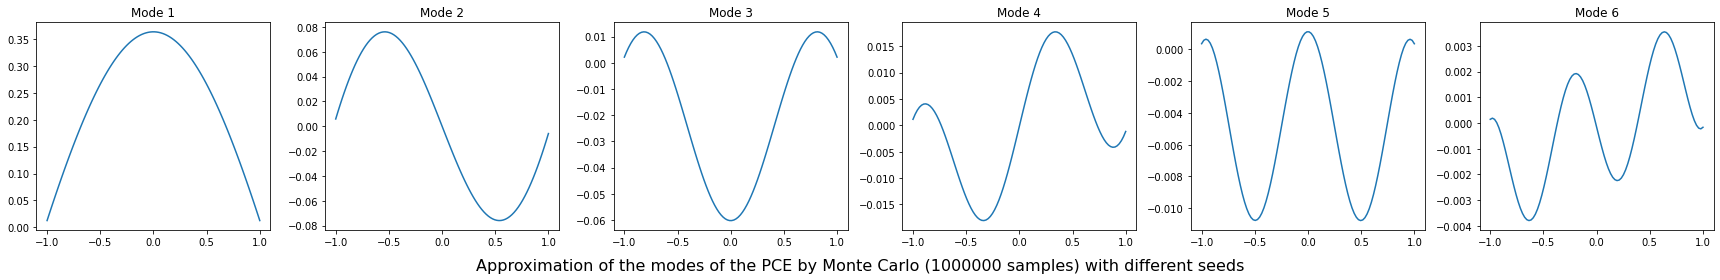

In [ ]:
#save the reference solution
mean_modes = np.zeros((truncation_order, len(x_test)))
for seed in range(0,5):
    mean_modes += modes_functions[seed]
mean_modes = mean_modes/5

np.save('reference_PCE_modes.npy', mean_modes)

fig, axs = plt.subplots(1, len(modes_functions[0]), figsize=(24, 4))
for i, mode in enumerate(mean_modes):
    axs[i].plot(x_test, mode)
    axs[i].set_title(f"Mode {i+1}")
plt.suptitle(f"Approximation of the modes of the PCE by Monte Carlo ({n_xi_samples} samples) with different seeds", y=0, fontsize=16)
plt.tight_layout()


### ⚠ 1000 Monte Carlo samples are not enough to get a good approximation of modes upper than 3.

Monte Carlo converges in $O(N^{-1/2})$ where $N$ is the number of samples.
To be able to approximate modes 6 (order of magnitude $10^{-3}$) we need at least $10^{-4}$ accuracy, which means $10^8$ samples

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import time


# Ensure reproducibility
torch.manual_seed(0)

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
def grad_i(Y,X,i):
    #calculate the partial derivative of y with respect to x_i
    return torch.autograd.grad(Y, X, grad_outputs=torch.ones_like(Y), create_graph=True)[0][:, None, i].flatten()
print("Using GPU:", torch.cuda.is_available())

Using GPU: False


In [ ]:
def f0(x):
    if isinstance(x, torch.Tensor):
        return 10 * torch.sin(torch.pi * x)
    else:
        return 10 * np.sin(np.pi * x)
    
def hermite_polynomial(order, xi):
    """Compute the Hermite polynomial of a given order for xi."""
    if order == 0:
        return torch.ones_like(xi)
    elif order == 1:
        return xi
    else:
        H0 = torch.ones_like(xi)
        H1 = xi
        for _ in range(2, order + 1):
            H_next = xi * H1 - (order - 1) * H0
            H0, H1 = H1, H_next
        return H1

def generate_pce_basis(xi, max_order):
    """Generate PCE basis up to a given order for xi."""
    basis = []
    for order in range(max_order + 1):
        basis.append(hermite_polynomial(order, xi))
    return torch.stack(basis, dim=-1)

class MeanNN(nn.Module):
    """Neural network to approximate the mean function."""
    def __init__(self, input_dim, hidden_dim=4):
        super(MeanNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.fc3(x)
        return x


class PCECoefficientNN(nn.Module):
    """Neural network to approximate the coefficients of the PCE."""
    def __init__(self, input_dim, hidden_dim=32, output_dim=None):
        super(PCECoefficientNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

def l2_regularization(model, lambda_reg=1e-3):
    l2_reg = None
    for W in model.parameters():
        if l2_reg is None:
            l2_reg = W.norm(2)
        else:
            l2_reg = l2_reg + W.norm(2)
    return lambda_reg * l2_reg
    
def compute_loss(x, xi,f, mean_model, coeffs_model, batch_size):

    indices = torch.randperm(xi.size(0))[:batch_size]
    xi_batch = xi[indices]
    f_batch = f[indices]
    loss = 0
    for i in range(batch_size):
        xi_sample = xi_batch[i, :]
        f_sample = f_batch[i, :]
        # f_sample = f_from_xi(xi_sample.numpy(), x.detach().numpy(), eigenvalues, eigenvectors, f0) #f_batch[i, :]
        # f_sample = torch.tensor(f_sample)
        # Compute the PCE basis
        pce_basis = hermite_polynomial(1, xi_sample)

        # Total predicted u
        u_predicted = mean_model(x).flatten() + pce_basis @  coeffs_model(x).T
        # 1st derivative of u wrt x
        du_dx = grad_i(u_predicted, x, 0)  
        # 2nd derivative of u wrt x (Laplacian in 1D)
        d2u_dx2 = grad_i(du_dx, x, 0)
    
    
        # PDE Residual Loss: -d^2u/dx^2 - f(x, w)
        pde_residual = d2u_dx2 + f_sample
        pde_loss = torch.mean(pde_residual**2) / len(x)

        # # Boundary Conditions Loss
        bc_loss_left = u_predicted[0]**2
        bc_loss_right = u_predicted[-1]**2
        bc_loss = (bc_loss_left + bc_loss_right) / 2

        # Combine the losses
        loss += pde_loss + bc_loss
    
    loss = loss / batch_size 
    return loss

In [ ]:
def train(mean_model, coeffs_model, data, batch_size=100, optimizer_choice="adam", epochs=1000, lr=0.001, lambda_reg=1e-4):
    t_start = time.time()
    x_torch, xi_torch, f_torch = data
    if optimizer_choice == "adam":
        optimizer = torch.optim.Adam(list(mean_model.parameters()) + list(coeffs_model.parameters()), lr=lr)
        for epoch in range(epochs):
            optimizer.zero_grad()
            
            loss = compute_loss(x_torch, xi_torch, f_torch, mean_model, coeffs_model, batch_size)
            l2_reg = l2_regularization(mean_model,lambda_reg) + l2_regularization(coeffs_model,lambda_reg)
            loss += l2_reg
            loss.backward()
            optimizer.step()
            
            # Print progress
            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {loss.item():.3f}, Elapsed time: {time.time()-t_start:.0f}")
                
    elif optimizer_choice == "l-bfgs":
        optimizer = torch.optim.LBFGS(list(mean_model.parameters()) + list(coeffs_model.parameters()), lr=lr, max_iter=20, history_size=100)

        for epoch in range(epochs):
            def closure():
                optimizer.zero_grad()
                
                loss = compute_loss(x_torch, xi_torch, f_torch, mean_model, coeffs_model, batch_size)
                l2_reg = l2_regularization(mean_model,lambda_reg) + l2_regularization(coeffs_model,lambda_reg)
                loss += l2_reg
                loss.backward()
                return loss

            optimizer.step(closure)
            
            # Print progress
            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {closure().item():.3f}, Elapsed time: {time.time()-t_start:.0f}")
    else:
        print(f"Optimizer choice {optimizer_choice} not recognized. Please choose either 'adam' or 'l-bfgs'.")

In [1]:
n_x_points = 100
n_xi_samples = 1000
n_sensors = 13
sensors_indices = np.linspace(0, n_x_points - 1, n_sensors, dtype=int)

xi_train = np.random.randn(n_xi_samples, truncation_order)
x_train = np.linspace(-1, 1, n_x_points)

eigenvalues, eigenvectors = KL_expansion(x_train, kernel, truncation_order)
f_samples = np.array([f_from_xi(xi, x_train, eigenvalues, eigenvectors, f0) for xi in xi_train])

f_torch = torch.tensor(f_samples[:,sensors_indices]).float().to(device)
xi_torch = torch.tensor(xi_train).float().to(device)
x_torch = torch.tensor(x_train[sensors_indices]).unsqueeze(-1).float().to(device)
x_torch.requires_grad = True

# Models, Loss, and Optimizer
mean_model = MeanNN(input_dim=1).to(device)
coeffs_model = PCECoefficientNN(input_dim=1, output_dim=truncation_order).to(device)

NameError: name 'np' is not defined

In [ ]:
# Training
batch_size = 100
learning_rate = 1e-3
lambda_reg = 1e-3
epochs = 20000

data = x_torch, xi_torch, f_torch 

# train(mean_model, coeffs_model, data, batch_size=batch_size, optimizer_choice="adam", epochs=epochs, lr=learning_rate, lambda_reg=lambda_reg)
train(mean_model, coeffs_model, data, batch_size=100, optimizer_choice="l-bfgs", epochs=epochs, lambda_reg=lambda_reg)

NameError: name 'x_torch' is not defined

Text(0.5, 1.0, 'Comparison of Exact and Predicted Standard Deviations')

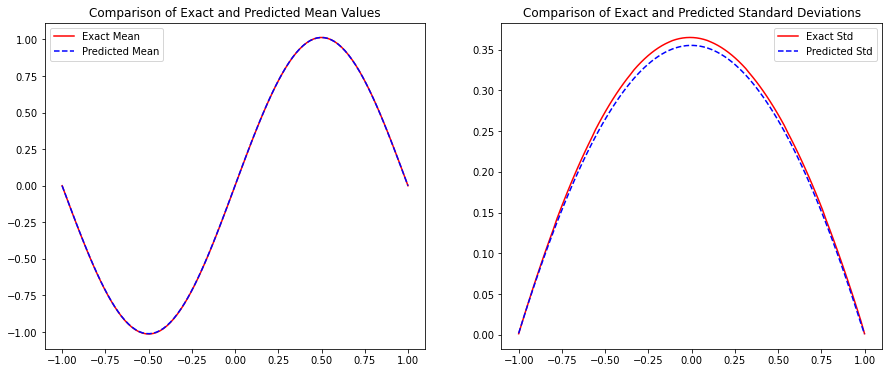

In [ ]:
subsample_ind = [int(i) for i in np.linspace(0,len(u_std)-1,100)]
x_values = np.linspace(-1, 1, 100)
x_tensor = torch.tensor(x_values).float().view(-1, 1)

u_mean = f0(x_values)/np.pi**2

# Evaluate the mean_model to get the predicted mean values
with torch.no_grad():
    predicted_mean = mean_model(x_tensor).numpy()
    coeffs_output = coeffs_model(x_tensor).numpy()

model_std = np.sqrt(np.sum(coeffs_output**2, axis=1))

# Plot the comparison
fig, axs = plt.subplots(1,2,figsize=(15, 6))
axs[0].plot(x_values, u_mean, 'r-', label="Exact Mean")
axs[0].plot(x_values, predicted_mean, 'b--', label="Predicted Mean")
axs[0].legend()
axs[0].set_title('Comparison of Exact and Predicted Mean Values')

axs[1].plot(x_values, u_std[subsample_ind], 'r-', label="Exact Std")
axs[1].plot(x_values, model_std, 'b--', label="Predicted Std")
axs[1].legend()
axs[1].set_title('Comparison of Exact and Predicted Standard Deviations')


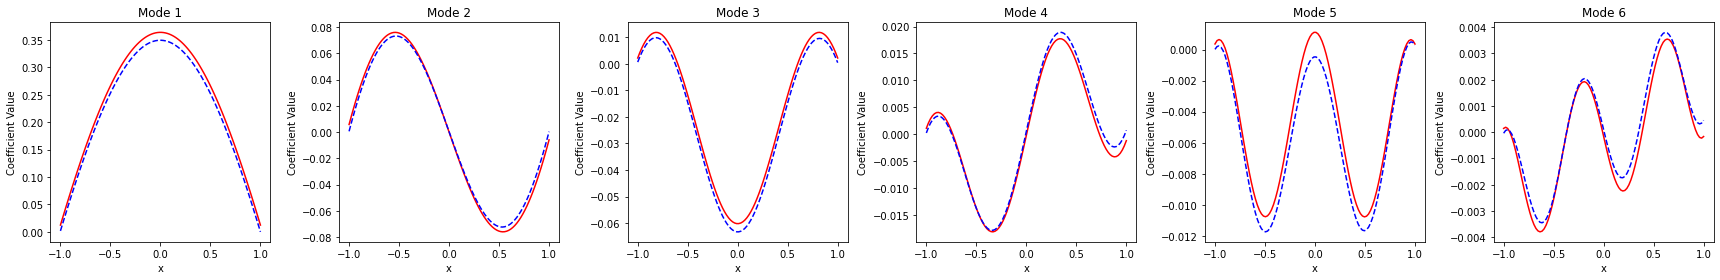

In [ ]:
def plot_modes(x_values,coeffs_model, modes_to_plot, reference_modes=None):
    # Convert x_values to a PyTorch tensor
    x_tensor = torch.tensor(x_values, dtype=torch.float32).view(-1, 1)
    x_ref = np.linspace(-1, 1, 100)
    # Evaluate the model (turn off gradient computation for evaluation)
    with torch.no_grad():
        coeffs_output = coeffs_model(x_tensor)

    # Convert the outputs back to numpy for plotting
    coeffs_numpy = coeffs_output.numpy()

    # Number of modes to plot
    num_modes = len(modes_to_plot)
    
    # Create subplots for each mode
    fig, axs = plt.subplots(1, num_modes, figsize=(4*num_modes, 4))
    
    for i, mode in enumerate(modes_to_plot):
        if num_modes > 1:
            ax = axs[i]
        else:
            ax = axs
        if reference_modes is not None:
            axs[i].plot(x_ref, reference_modes[i,:], 'r-', label=f"Reference")
        ax.plot(x_values, coeffs_numpy[:, mode-1], 'b--', label=f"PINN-PCE approx.")
        ax.set_title(f"Mode {mode}")
        ax.set_xlabel('x')
        ax.set_ylabel('Coefficient Value')
    
    plt.tight_layout()
    plt.show()

# Define the inputs and modes you want to visualize
x_values = np.linspace(-1, 1, 100)
modes_to_plot = [1,2,3,4,5, 6]  # For example, if you want to plot the first three modes. Adjust this as needed.

reference_modes = np.load('reference_PCE_modes.npy')
plot_modes(x_values,coeffs_model, modes_to_plot, reference_modes=reference_modes)